<a href="https://colab.research.google.com/github/aviralsomani/driv-face-classifier/blob/master/AviralSomani_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=a9802b88fe65237454e1c8e25e8459f43360390c28319d07c48cd3e74d117d59
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [2]:
import wget
import os
from zipfile import PyZipFile
import shutil
import glob
import pandas as pd
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import random
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

tmp_dir = 'data/tmp'
img_dir = 'data/img'
trn_dir = 'data/trn'
val_dir = 'data/val'
uci_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00378/DrivFace.zip'

Using TensorFlow backend.


In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
def load_data():
  if not os.path.exists(img_dir):
    os.makedirs(tmp_dir)
    os.makedirs(img_dir)
    print("Downloading dataset to "+ tmp_dir)
    file = wget.download(uci_url, out=tmp_dir)
    print("\nUnzipping the files..")
    pzf = PyZipFile(file)
    pzf.extractall(tmp_dir)
    pzf = PyZipFile(tmp_dir + '/DrivFace/DrivImages.zip')
    pzf.extractall(tmp_dir)
    print("Moving files to " + img_dir)
    for file in os.listdir(tmp_dir + '/DrivImages'):
      shutil.move(tmp_dir+'/DrivImages/'+file, img_dir+'/'+file)
    shutil.move(tmp_dir + '/DrivFace/drivPoints.txt', img_dir + '/drivPoints.txt')
    shutil.rmtree(tmp_dir)

In [0]:
def move_train_val(train_dir, validation_dir, files, ratio):
  ind = 0
  for fname in files:
    src = os.path.join(img_dir, fname + '.jpg')
    t_dest = os.path.join(train_dir, fname + '')
    ind = ind + 1
    if ind < len(files)*ratio:
      shutil.move(os.path.join(img_dir, fname + '.jpg'),
                  os.path.join(train_dir, fname + '.jpg'))
    else:
      shutil.move(os.path.join(img_dir, fname + '.jpg'),
                  os.path.join(validation_dir, fname + '.jpg'))

In [0]:
import matplotlib.pyplot as plt
def show_plots(hist):
  acc = hist.history['acc']
  val_acc = hist.history['val_acc']
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.ylim(0, 1)
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
  plt.plot(epochs, acc, 'bo', label='Training Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()


In [0]:
def split_data(img_dir, trn_dir, val_dir, ratio):
  if not os.path.exists(trn_dir):
    os.makedirs(trn_dir)
    os.makedirs(val_dir)
    tff_dir = os.path.join(trn_dir, 'ff')
    tll_dir = os.path.join(trn_dir, 'll')
    tlr_dir = os.path.join(trn_dir, 'lr')
    os.makedirs(tff_dir)
    os.makedirs(tll_dir)
    os.makedirs(tlr_dir)
    vff_dir = os.path.join(val_dir, 'ff')
    vll_dir = os.path.join(val_dir, 'll')
    vlr_dir = os.path.join(val_dir, 'lr')
    os.makedirs(vff_dir)
    os.makedirs(vll_dir)
    os.makedirs(vlr_dir)
    df = pd.read_csv(img_dir + '/drivPoints.txt')['fileName']
    ff = [f for f in df if 'f' in f]
    random.shuffle(ff)
    ll = [f for f in df if 'll' in f]
    random.shuffle(ll)
    lr = [f for f in df if 'lr' in f]
    random.shuffle(lr)
    ind = 0
    move_train_val(tff_dir, vff_dir, ff, ratio)
    move_train_val(tll_dir, vll_dir, ll, ratio)
    move_train_val(tlr_dir, vlr_dir, lr, ratio)

In [0]:
def return_data(img_dir, trn_dir, val_dir):
  for out in [trn_dir, val_dir]:
    for lab in ['ff', 'll', 'lr']:
      src = os.path.join(out, lab)
      files = os.listdir(src)
      for f in files:
        shutil.move(os.path.join(src, f), img_dir)
    shutil.rmtree(out)

In [0]:
def split_k_bins(trn_dir, k):
  bins = list(range(0, k))
  for b in bins:
    path = os.path.join(trn_dir, ('b'+str(b)))
    if not os.path.exists(path):
      os.makedirs(path)
      os.makedirs(os.path.join(path, 'ff'))
      os.makedirs(os.path.join(path, 'll'))
      os.makedirs(os.path.join(path, 'lr'))
  for lab in ['ff', 'll', 'lr']:
    src = os.path.join(trn_dir, lab)
    for f in os.listdir(src):
      if len(bins) == 0:
        bins = list(range(0, k))
      bin_num = random.choice(bins)
      bins.remove(bin_num)
      bin_dir = os.path.join(trn_dir, ('b' + str(bin_num)))
      shutil.move(os.path.join(src, f), os.path.join(bin_dir, lab))
    shutil.rmtree(src)

In [0]:
def coalesce_train_val(trn_dir, j):
  target = 'b' + str(j)
  bins = [b for b in os.listdir(trn_dir) if b != target]
  ingroup = os.path.join(trn_dir, 'in')
  os.makedirs(ingroup)
  os.makedirs(os.path.join(ingroup, 'ff'))
  os.makedirs(os.path.join(ingroup, 'll'))
  os.makedirs(os.path.join(ingroup, 'lr'))
  for b in bins:
    src = os.path.join(trn_dir, b)
    for lab in ['ff', 'll', 'lr']:
      srclab = os.path.join(src, lab)
      for f in os.listdir(srclab):
        shutil.copy(os.path.join(srclab, f), os.path.join(ingroup, lab))
  outgroup = os.path.join(trn_dir, 'out')
  os.makedirs(outgroup)
  os.makedirs(os.path.join(outgroup, 'ff'))
  os.makedirs(os.path.join(outgroup, 'll'))
  os.makedirs(os.path.join(outgroup, 'lr'))
  outbin = os.path.join(trn_dir, target)
  for lab in ['ff', 'll', 'lr']:
    srclab = os.path.join(outbin, lab)
    for f in os.listdir(srclab):
      shutil.copy(os.path.join(srclab, f), os.path.join(outgroup, lab))


In [0]:
def decoalesce_train_val(trn_dir):
  ingroup = os.path.join(trn_dir, 'in')
  outgroup = os.path.join(trn_dir, 'out')
  shutil.rmtree(ingroup)
  shutil.rmtree(outgroup)

In [0]:
def return_bins(trn_dir):
  bins = os.listdir(trn_dir)
  os.makedirs(os.path.join(trn_dir, 'ff'))
  os.makedirs(os.path.join(trn_dir, 'll'))
  os.makedirs(os.path.join(trn_dir, 'lr'))
  for b in bins:
    src = os.path.join(trn_dir, b)
    for lab in ['ff', 'll', 'lr']:
      insrc = os.path.join(src, lab)
      for f in os.listdir(insrc):
        shutil.move(os.path.join(insrc, f), os.path.join(trn_dir, lab))
    shutil.rmtree(src)

In [0]:
from keras import layers
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

In [0]:
def run_k_fold_cross_val(model, k, steps_per_epoch=100, epochs=10, validation_steps=50):
  tr_dgen = ImageDataGenerator(rescale=1./255)
  vl_dgen = ImageDataGenerator(rescale=1./255)
  split_k_bins(trn_dir, k)
  for i in range(0, k):
    print('Bin ', i+1, 'out of', k)
    coalesce_train_val(trn_dir, i)
    tr_gen = tr_dgen.flow_from_directory(os.path.join(trn_dir, 'in'), target_size=(64, 64),
                                         batch_size=20, class_mode='categorical')

    vl_gen = vl_dgen.flow_from_directory(os.path.join(trn_dir, 'out'), target_size=(64, 64),
                                         batch_size=20, class_mode='categorical')
                                         
    hist = model.fit_generator(tr_gen, steps_per_epoch=steps_per_epoch, epochs=epochs,
                               validation_data=vl_gen, validation_steps=validation_steps)
    show_plots(hist)
    decoalesce_train_val(trn_dir)
  return_bins(trn_dir)


In [15]:
load_data()
split_data(img_dir, trn_dir, val_dir, 0.8)


Unzipping the files..
Moving files to data/img


In [0]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', 
                        padding='same', 
                        input_shape=(64, 64, 3)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', 
                        padding='same'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(256, (3,3), activation='relu',
                        padding='same'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)              

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['acc'])

Bin  1 out of 3
Found 322 images belonging to 3 classes.
Found 161 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 19s 191ms/step - loss: 0.4554 - acc: 0.8980 - val_loss: 0.6681 - val_acc: 0.9050
Epoch 2/10
100/100 [==============================] - 13s 125ms/step - loss: 0.2265 - acc: 0.9197 - val_loss: 0.2429 - val_acc: 0.9323
Epoch 3/10
100/100 [==============================] - 12s 123ms/step - loss: 0.1013 - acc: 0.9667 - val_loss: 0.6536 - val_acc: 0.9381
Epoch 4/10
100/100 [==============================] - 12s 123ms/step - loss: 0.0522 - acc: 0.9826 - val_loss: 0.3126 - val_acc: 0.9492
Epoch 5/10
100/100 [==============================] - 12s 122ms/step - loss: 0.0390 - acc: 0.9868 - val_loss: 5.3550e-04 - val_acc: 0.9514
Epoch 6/10
100/100 [==============================] - 12s 124ms/step - loss: 0.0154 - acc: 0.9958 - val_loss: 0.4385 - val_acc: 0.9447
Epoch 7/10
100/100 [==============================] - 12s 121ms/step - loss: 0.0015 - ac

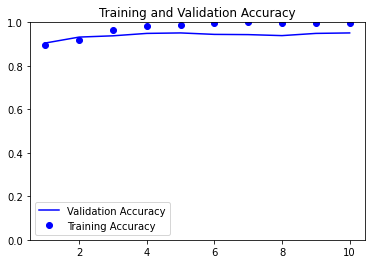

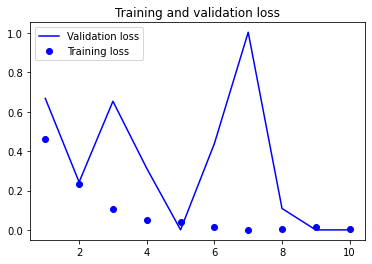

Bin  2 out of 3
Found 322 images belonging to 3 classes.
Found 161 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 124ms/step - loss: 0.1116 - acc: 0.9704 - val_loss: 0.0470 - val_acc: 0.9867
Epoch 2/10
100/100 [==============================] - 12s 125ms/step - loss: 0.0204 - acc: 0.9947 - val_loss: 3.3136e-05 - val_acc: 0.9887
Epoch 3/10
100/100 [==============================] - 12s 124ms/step - loss: 0.0106 - acc: 0.9963 - val_loss: 0.0071 - val_acc: 0.9746
Epoch 4/10
100/100 [==============================] - 13s 125ms/step - loss: 0.0053 - acc: 0.9974 - val_loss: 0.0033 - val_acc: 0.9831
Epoch 5/10
100/100 [==============================] - 12s 122ms/step - loss: 7.2504e-04 - acc: 1.0000 - val_loss: 7.7486e-07 - val_acc: 0.9867
Epoch 6/10
100/100 [==============================] - 12s 123ms/step - loss: 6.5770e-04 - acc: 1.0000 - val_loss: 0.1648 - val_acc: 0.9808
Epoch 7/10
100/100 [==============================] - 12s 121ms/step - loss:

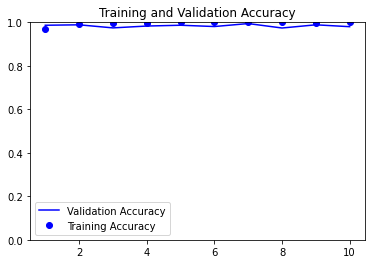

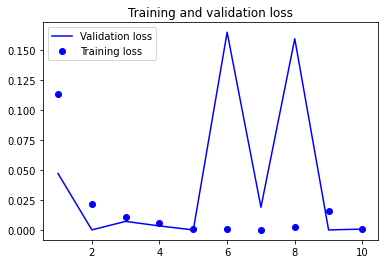

Bin  3 out of 3
Found 322 images belonging to 3 classes.
Found 161 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 13s 126ms/step - loss: 0.0460 - acc: 0.9864 - val_loss: 3.1531e-06 - val_acc: 0.9867
Epoch 2/10
100/100 [==============================] - 12s 124ms/step - loss: 0.0111 - acc: 0.9973 - val_loss: 1.1467e-05 - val_acc: 0.9944
Epoch 3/10
100/100 [==============================] - 12s 123ms/step - loss: 4.1187e-04 - acc: 1.0000 - val_loss: 2.4748e-05 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 12s 124ms/step - loss: 1.6704e-04 - acc: 1.0000 - val_loss: 7.6289e-06 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 12s 123ms/step - loss: 1.4971e-04 - acc: 1.0000 - val_loss: 5.9605e-09 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 12s 123ms/step - loss: 5.1360e-05 - acc: 1.0000 - val_loss: 7.5335e-06 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] 

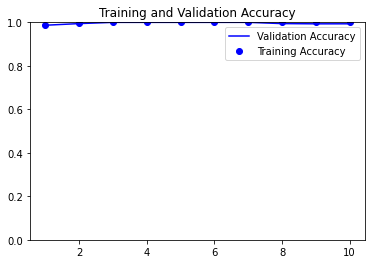

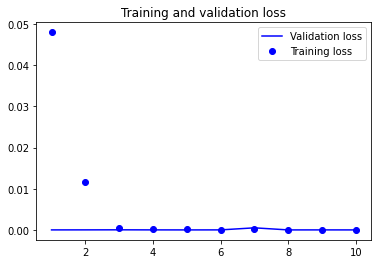

In [19]:
run_k_fold_cross_val(model, k=3)

In [20]:
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir, target_size=(64, 64),
                                         batch_size=20, class_mode='categorical')

Found 123 images belonging to 3 classes.


In [21]:
model.evaluate_generator(test_gen)


[3.4568900446174666e-05, 0.9512194991111755]

In [22]:
model2 = models.Sequential()
model2.add(layers.Conv2D(256, (3, 3), activation='relu', 
                         padding='same', 
                         input_shape=(64, 64, 3)))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu',
                        padding='same'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dense(3, activation='softmax'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 256)       7168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)       295040    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

Bin  1 out of 15
Found 451 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 14s 141ms/step - loss: 0.5801 - acc: 0.8182 - val_loss: 0.5508 - val_acc: 0.9062
Epoch 2/5
100/100 [==============================] - 13s 132ms/step - loss: 0.3651 - acc: 0.9023 - val_loss: 0.2042 - val_acc: 0.9062
Epoch 3/5
100/100 [==============================] - 13s 134ms/step - loss: 0.3158 - acc: 0.9002 - val_loss: 0.1514 - val_acc: 0.9062
Epoch 4/5
100/100 [==============================] - 13s 131ms/step - loss: 0.2441 - acc: 0.9028 - val_loss: 0.4100 - val_acc: 0.9062
Epoch 5/5
100/100 [==============================] - 13s 128ms/step - loss: 0.2026 - acc: 0.9199 - val_loss: 0.3610 - val_acc: 0.9375


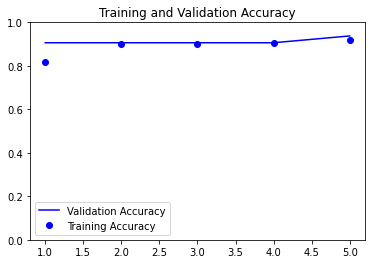

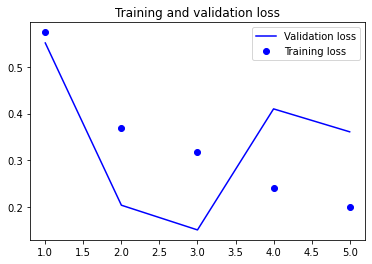

Bin  2 out of 15
Found 451 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 14s 137ms/step - loss: 0.1597 - acc: 0.9420 - val_loss: 0.0441 - val_acc: 0.9688
Epoch 2/5
100/100 [==============================] - 13s 127ms/step - loss: 0.1126 - acc: 0.9586 - val_loss: 0.0176 - val_acc: 0.9688
Epoch 3/5
100/100 [==============================] - 13s 131ms/step - loss: 0.0967 - acc: 0.9679 - val_loss: 0.0148 - val_acc: 0.9688
Epoch 4/5
100/100 [==============================] - 13s 130ms/step - loss: 0.0741 - acc: 0.9705 - val_loss: 0.1534 - val_acc: 0.9688
Epoch 5/5
100/100 [==============================] - 13s 128ms/step - loss: 0.0618 - acc: 0.9760 - val_loss: 0.0080 - val_acc: 0.9688


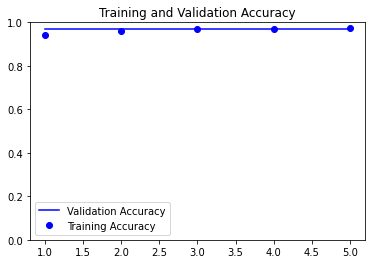

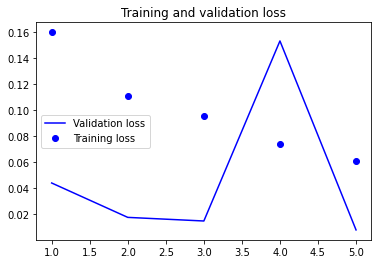

Bin  3 out of 15
Found 451 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 14s 139ms/step - loss: 0.0476 - acc: 0.9816 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 13s 127ms/step - loss: 0.0442 - acc: 0.9837 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 13s 133ms/step - loss: 0.0376 - acc: 0.9873 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 13s 129ms/step - loss: 0.0465 - acc: 0.9821 - val_loss: 0.1006 - val_acc: 0.9688
Epoch 5/5
100/100 [==============================] - 13s 127ms/step - loss: 0.0456 - acc: 0.9842 - val_loss: 0.0112 - val_acc: 1.0000


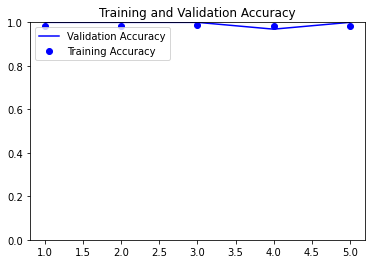

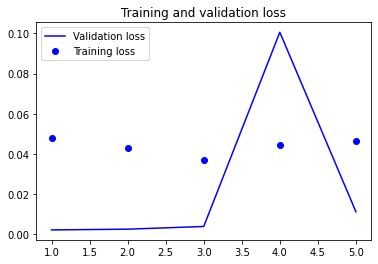

Bin  4 out of 15
Found 451 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 14s 137ms/step - loss: 0.0200 - acc: 0.9929 - val_loss: 5.6127e-06 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 13s 127ms/step - loss: 0.0147 - acc: 0.9949 - val_loss: 2.0214e-05 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 13s 132ms/step - loss: 0.0289 - acc: 0.9913 - val_loss: 3.9736e-08 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 13s 129ms/step - loss: 0.0187 - acc: 0.9944 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 13s 126ms/step - loss: 0.0210 - acc: 0.9934 - val_loss: 0.0065 - val_acc: 1.0000


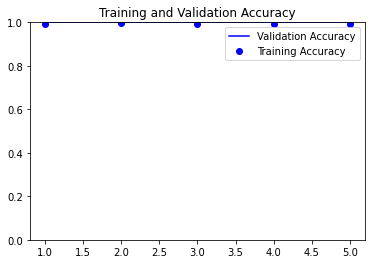

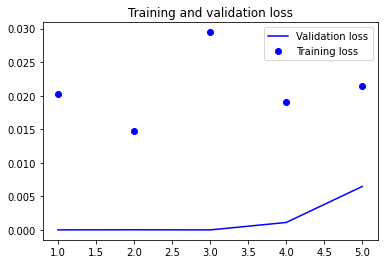

Bin  5 out of 15
Found 451 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 14s 139ms/step - loss: 0.0138 - acc: 0.9959 - val_loss: 4.7285e-06 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 13s 129ms/step - loss: 0.0079 - acc: 0.9985 - val_loss: 0.2496 - val_acc: 0.9375
Epoch 3/5
100/100 [==============================] - 13s 133ms/step - loss: 0.0204 - acc: 0.9934 - val_loss: 4.0174e-05 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 13s 127ms/step - loss: 0.0187 - acc: 0.9929 - val_loss: 6.7061e-04 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 13s 127ms/step - loss: 0.0161 - acc: 0.9954 - val_loss: 4.9671e-08 - val_acc: 0.9688


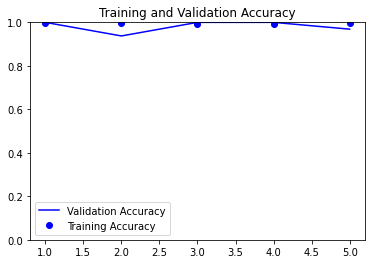

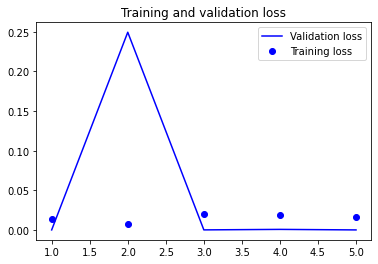

Bin  6 out of 15
Found 451 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 14s 141ms/step - loss: 0.0125 - acc: 0.9944 - val_loss: 4.9670e-07 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 13s 127ms/step - loss: 0.0097 - acc: 0.9975 - val_loss: 9.9341e-09 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 13s 133ms/step - loss: 0.0715 - acc: 0.9806 - val_loss: 0.0082 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 13s 130ms/step - loss: 0.0462 - acc: 0.9836 - val_loss: 1.2295e-04 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 13s 128ms/step - loss: 0.0113 - acc: 0.9975 - val_loss: 1.0316e-04 - val_acc: 1.0000


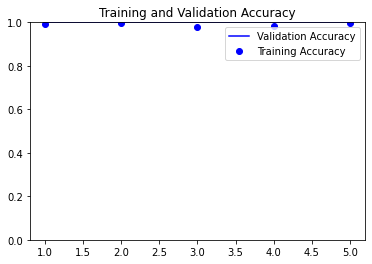

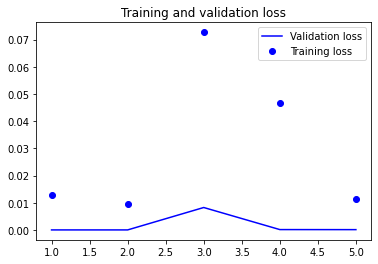

Bin  7 out of 15
Found 450 images belonging to 3 classes.
Found 33 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 14s 139ms/step - loss: 0.0111 - acc: 0.9959 - val_loss: 0.0290 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 13s 128ms/step - loss: 0.0056 - acc: 0.9985 - val_loss: 6.4436e-05 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 13s 133ms/step - loss: 0.0034 - acc: 0.9995 - val_loss: 2.4647e-05 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 13s 132ms/step - loss: 0.0100 - acc: 0.9959 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 13s 129ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 1.3800e-05 - val_acc: 1.0000


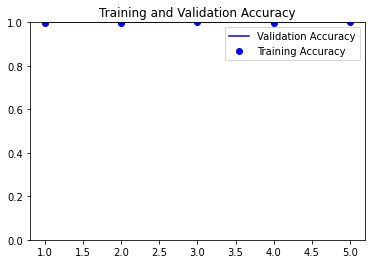

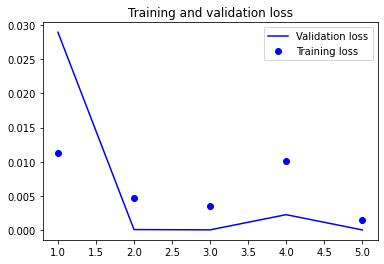

Bin  8 out of 15
Found 451 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 14s 139ms/step - loss: 0.0084 - acc: 0.9969 - val_loss: 2.9802e-07 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 13s 128ms/step - loss: 0.0057 - acc: 0.9990 - val_loss: 4.4702e-06 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 13s 134ms/step - loss: 0.0039 - acc: 0.9990 - val_loss: 1.9868e-08 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 13s 130ms/step - loss: 0.0064 - acc: 0.9975 - val_loss: 4.8180e-06 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 13s 130ms/step - loss: 0.0023 - acc: 0.9995 - val_loss: 2.9802e-08 - val_acc: 1.0000


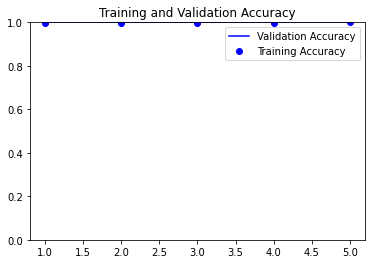

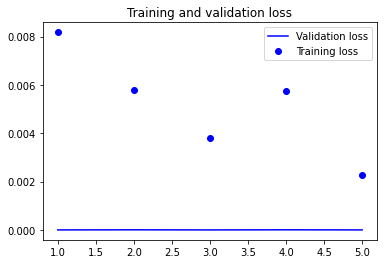

Bin  9 out of 15
Found 451 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 14s 139ms/step - loss: 0.0040 - acc: 0.9985 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 13s 127ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 1.9868e-08 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 13s 133ms/step - loss: 0.0047 - acc: 0.9985 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 13s 130ms/step - loss: 0.0161 - acc: 0.9969 - val_loss: 1.4206e-06 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 13s 128ms/step - loss: 0.0039 - acc: 0.9980 - val_loss: 6.5565e-07 - val_acc: 1.0000


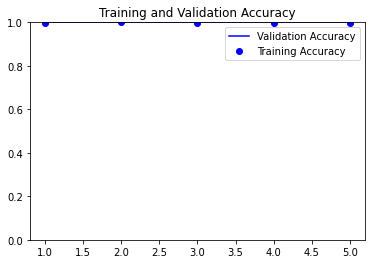

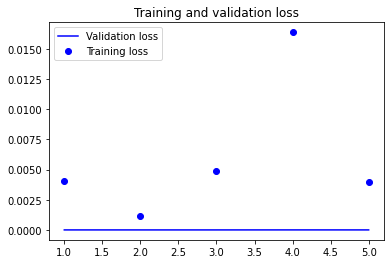

Bin  10 out of 15
Found 451 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 14s 138ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 13s 127ms/step - loss: 0.0072 - acc: 0.9980 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 13s 132ms/step - loss: 0.0019 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 13s 131ms/step - loss: 0.0052 - acc: 0.9985 - val_loss: 3.8875e-04 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 13s 128ms/step - loss: 0.0044 - acc: 0.9990 - val_loss: 1.0928e-07 - val_acc: 1.0000


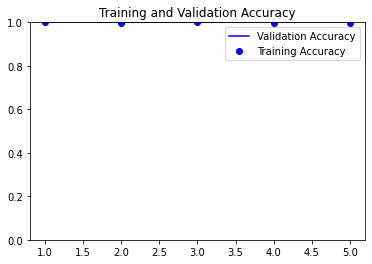

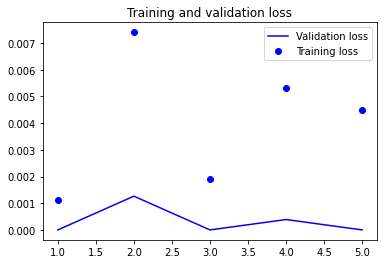

Bin  11 out of 15
Found 451 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 14s 137ms/step - loss: 0.0032 - acc: 0.9990 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 13s 129ms/step - loss: 0.0105 - acc: 0.9959 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 13s 133ms/step - loss: 0.0630 - acc: 0.9888 - val_loss: 2.9802e-08 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 13s 129ms/step - loss: 0.0352 - acc: 0.9873 - val_loss: 6.9539e-08 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 13s 128ms/step - loss: 0.0131 - acc: 0.9964 - val_loss: 3.8345e-06 - val_acc: 1.0000


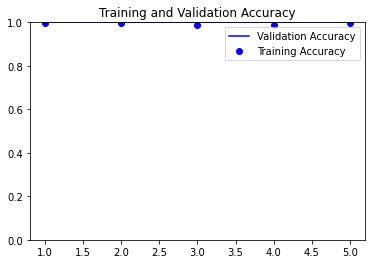

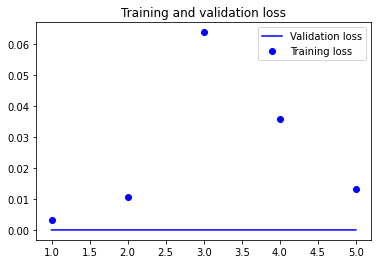

Bin  12 out of 15
Found 451 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 14s 138ms/step - loss: 0.0035 - acc: 0.9990 - val_loss: 9.9341e-09 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 13s 127ms/step - loss: 0.0049 - acc: 0.9980 - val_loss: 2.1060e-06 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 13s 133ms/step - loss: 0.0034 - acc: 0.9995 - val_loss: 4.3610e-06 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 13s 131ms/step - loss: 0.0026 - acc: 0.9990 - val_loss: 1.4206e-06 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 13s 128ms/step - loss: 0.0045 - acc: 0.9985 - val_loss: 4.0730e-07 - val_acc: 1.0000


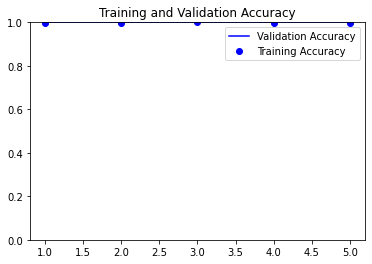

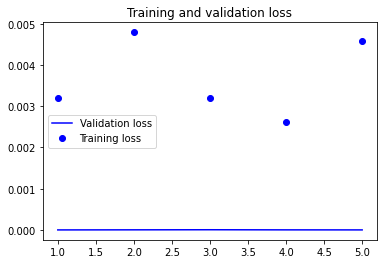

Bin  13 out of 15
Found 451 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 14s 138ms/step - loss: 0.0036 - acc: 0.9985 - val_loss: 5.2306e-04 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 13s 127ms/step - loss: 0.0035 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 13s 131ms/step - loss: 0.0016 - acc: 1.0000 - val_loss: 4.2120e-06 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 13s 131ms/step - loss: 9.4098e-04 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 13s 128ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000


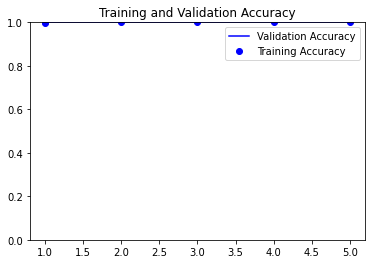

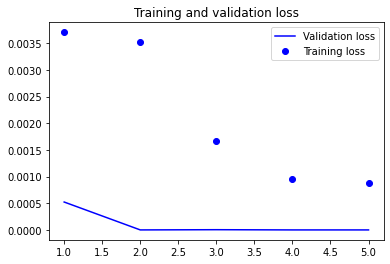

Bin  14 out of 15
Found 450 images belonging to 3 classes.
Found 33 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 14s 137ms/step - loss: 0.0052 - acc: 0.9980 - val_loss: 9.1699e-09 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 13s 126ms/step - loss: 2.5928e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 13s 132ms/step - loss: 0.0019 - acc: 0.9995 - val_loss: 9.1699e-09 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 13s 129ms/step - loss: 0.0010 - acc: 0.9995 - val_loss: 9.1699e-09 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 13s 128ms/step - loss: 6.3542e-05 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000


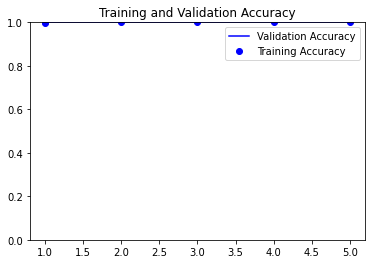

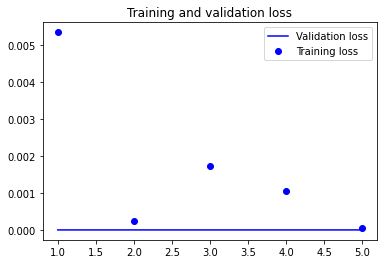

Bin  15 out of 15
Found 450 images belonging to 3 classes.
Found 33 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 14s 136ms/step - loss: 0.0013 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 13s 127ms/step - loss: 0.0026 - acc: 0.9990 - val_loss: 1.8340e-08 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 13s 134ms/step - loss: 0.0017 - acc: 0.9990 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 13s 129ms/step - loss: 0.0031 - acc: 0.9995 - val_loss: 1.8340e-08 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 13s 126ms/step - loss: 0.0016 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000


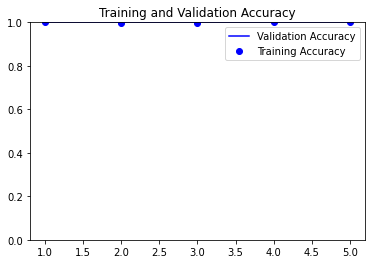

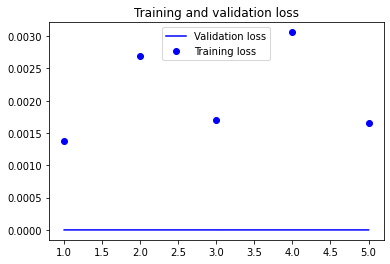

In [23]:
model2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['acc'])

run_k_fold_cross_val(model2, 15, steps_per_epoch=100, epochs=5, validation_steps=50)

In [24]:
model2.evaluate_generator(test_gen)

[0.0, 0.9593495726585388]

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 256)       7168      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 128)       295040    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)              

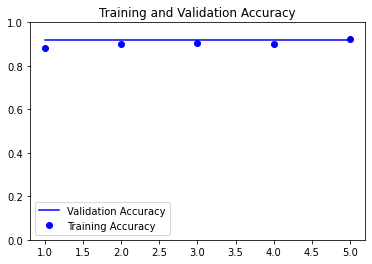

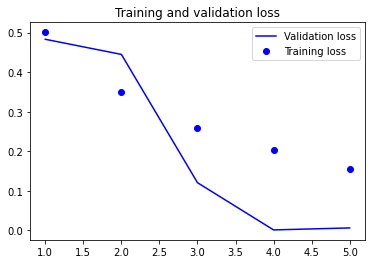

Bin  2 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 12s 118ms/step - loss: 0.1230 - acc: 0.9434 - val_loss: 0.0131 - val_acc: 0.9167
Epoch 2/5
100/100 [==============================] - 11s 109ms/step - loss: 0.1071 - acc: 0.9534 - val_loss: 0.0296 - val_acc: 0.9583
Epoch 3/5
100/100 [==============================] - 11s 115ms/step - loss: 0.0732 - acc: 0.9704 - val_loss: 1.5229e-05 - val_acc: 0.9583
Epoch 4/5
100/100 [==============================] - 11s 108ms/step - loss: 0.0749 - acc: 0.9689 - val_loss: 0.0186 - val_acc: 0.9583
Epoch 5/5
100/100 [==============================] - 11s 107ms/step - loss: 0.0561 - acc: 0.9759 - val_loss: 0.0152 - val_acc: 0.9583


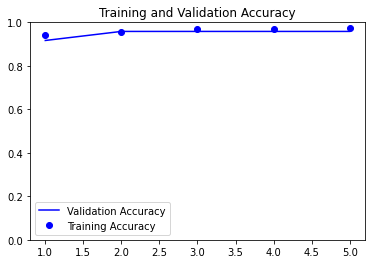

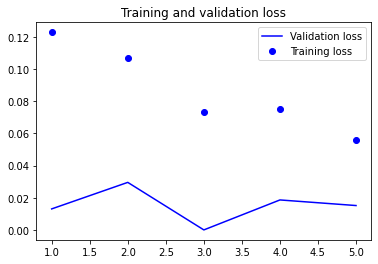

Bin  3 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 12s 119ms/step - loss: 0.1194 - acc: 0.9619 - val_loss: 0.0565 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 11s 107ms/step - loss: 0.0647 - acc: 0.9730 - val_loss: 0.0162 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 11s 113ms/step - loss: 0.0394 - acc: 0.9830 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 11s 112ms/step - loss: 0.0393 - acc: 0.9860 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 11s 108ms/step - loss: 0.0291 - acc: 0.9885 - val_loss: 0.0000e+00 - val_acc: 1.0000


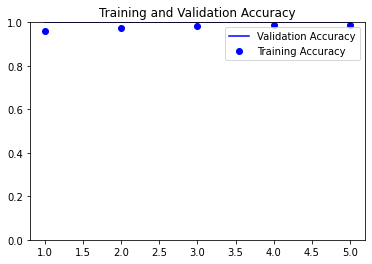

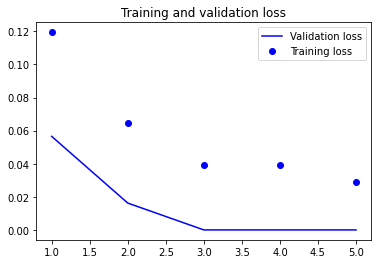

Bin  4 out of 20
Found 458 images belonging to 3 classes.
Found 25 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 12s 120ms/step - loss: 0.0352 - acc: 0.9869 - val_loss: 0.0177 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 11s 108ms/step - loss: 0.0231 - acc: 0.9910 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 11s 114ms/step - loss: 0.0257 - acc: 0.9884 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 11s 112ms/step - loss: 0.0319 - acc: 0.9890 - val_loss: 4.7684e-08 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 11s 108ms/step - loss: 0.0606 - acc: 0.9799 - val_loss: 0.0041 - val_acc: 1.0000


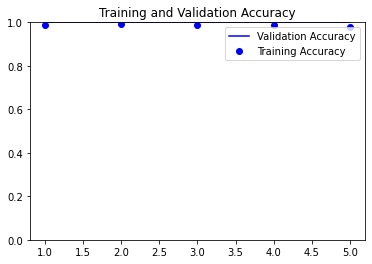

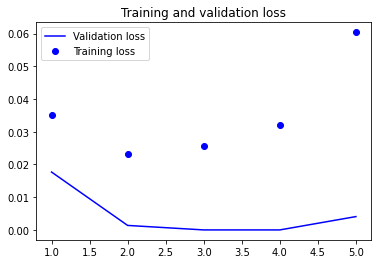

Bin  5 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 12s 120ms/step - loss: 0.0322 - acc: 0.9870 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 11s 111ms/step - loss: 0.0228 - acc: 0.9925 - val_loss: 9.5367e-07 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 11s 112ms/step - loss: 0.0167 - acc: 0.9940 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 11s 110ms/step - loss: 0.0209 - acc: 0.9915 - val_loss: 2.9802e-08 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 11s 109ms/step - loss: 0.0169 - acc: 0.9950 - val_loss: 0.0000e+00 - val_acc: 1.0000


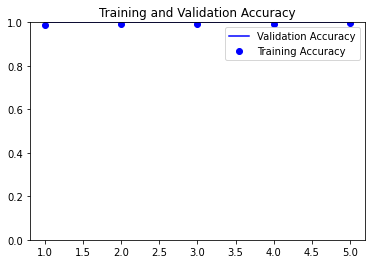

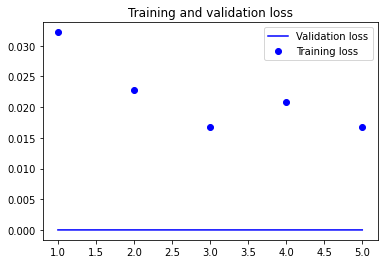

Bin  6 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 12s 117ms/step - loss: 0.0162 - acc: 0.9945 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 11s 109ms/step - loss: 0.0087 - acc: 0.9970 - val_loss: 1.5169e-05 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 11s 113ms/step - loss: 0.0122 - acc: 0.9955 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 11s 112ms/step - loss: 0.0140 - acc: 0.9955 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 11s 111ms/step - loss: 0.0161 - acc: 0.9970 - val_loss: 2.3396e-04 - val_acc: 1.0000


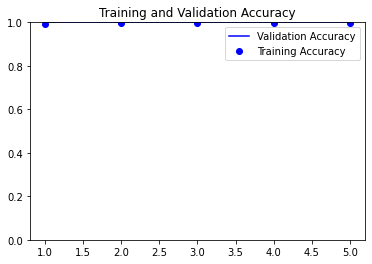

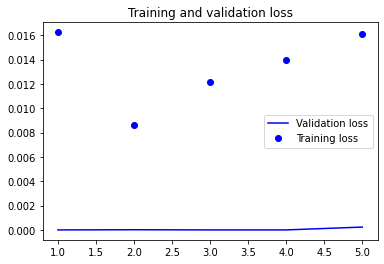

Bin  7 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 12s 122ms/step - loss: 0.0265 - acc: 0.9925 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 11s 113ms/step - loss: 0.0347 - acc: 0.9910 - val_loss: 9.8347e-07 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 12s 116ms/step - loss: 0.0147 - acc: 0.9955 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 11s 111ms/step - loss: 0.0100 - acc: 0.9960 - val_loss: 5.6624e-07 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 11s 108ms/step - loss: 0.0049 - acc: 0.9990 - val_loss: 0.0000e+00 - val_acc: 1.0000


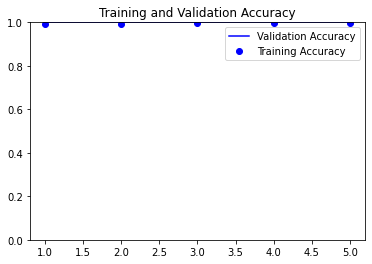

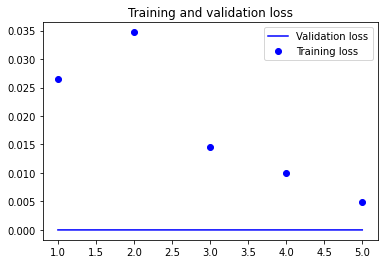

Bin  8 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 12s 120ms/step - loss: 0.0048 - acc: 0.9985 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 11s 108ms/step - loss: 0.0025 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 12s 115ms/step - loss: 0.0085 - acc: 0.9975 - val_loss: 4.8049e-04 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 11s 109ms/step - loss: 0.0087 - acc: 0.9965 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 11s 108ms/step - loss: 0.0029 - acc: 0.9995 - val_loss: 5.9605e-08 - val_acc: 1.0000


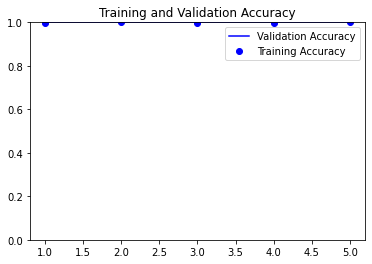

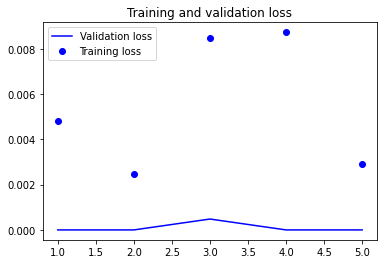

Bin  9 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 12s 121ms/step - loss: 0.0199 - acc: 0.9940 - val_loss: 2.9802e-08 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 11s 111ms/step - loss: 0.0254 - acc: 0.9920 - val_loss: 5.9605e-08 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 12s 115ms/step - loss: 0.0079 - acc: 0.9980 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 11s 110ms/step - loss: 0.0050 - acc: 0.9985 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 11s 108ms/step - loss: 0.0036 - acc: 0.9990 - val_loss: 0.0000e+00 - val_acc: 1.0000


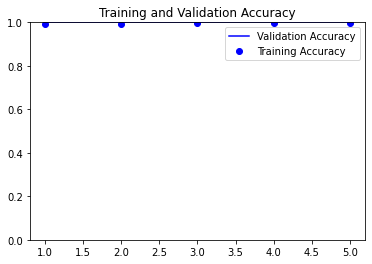

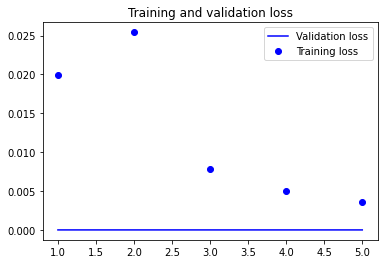

Bin  10 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 12s 121ms/step - loss: 0.0062 - acc: 0.9975 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 11s 109ms/step - loss: 0.0029 - acc: 0.9995 - val_loss: 2.9802e-08 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 12s 115ms/step - loss: 0.0029 - acc: 0.9990 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 11s 110ms/step - loss: 0.0017 - acc: 0.9990 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 11s 108ms/step - loss: 0.0016 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000


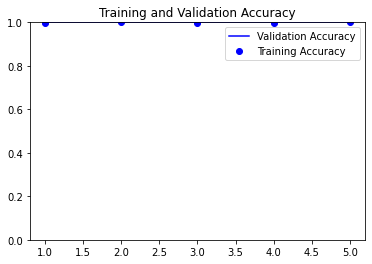

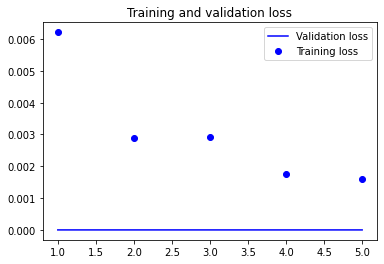

Bin  11 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 12s 122ms/step - loss: 0.0010 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 11s 110ms/step - loss: 0.0024 - acc: 0.9990 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 12s 116ms/step - loss: 0.0013 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 11s 112ms/step - loss: 8.5461e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 11s 108ms/step - loss: 0.0032 - acc: 0.9985 - val_loss: 0.0000e+00 - val_acc: 1.0000


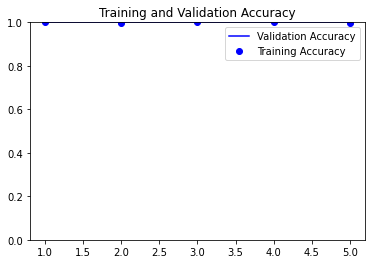

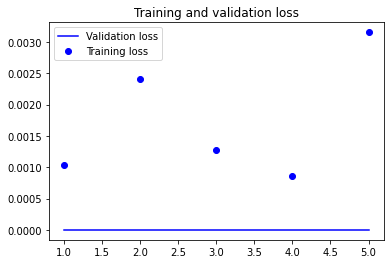

Bin  12 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 12s 120ms/step - loss: 0.0012 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 11s 110ms/step - loss: 0.0067 - acc: 0.9970 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 11s 114ms/step - loss: 0.0625 - acc: 0.9865 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 11s 110ms/step - loss: 0.0370 - acc: 0.9910 - val_loss: 2.9802e-08 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 11s 108ms/step - loss: 0.0150 - acc: 0.9955 - val_loss: 1.7881e-07 - val_acc: 1.0000


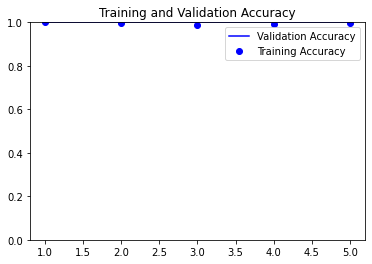

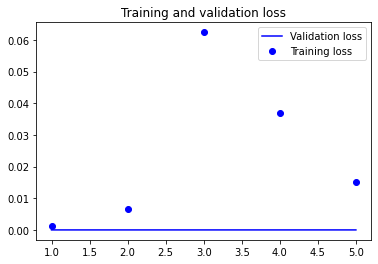

Bin  13 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 12s 122ms/step - loss: 0.0072 - acc: 0.9980 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 11s 107ms/step - loss: 0.0104 - acc: 0.9970 - val_loss: 0.1133 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 12s 116ms/step - loss: 0.0047 - acc: 0.9980 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 11s 111ms/step - loss: 0.0020 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 11s 108ms/step - loss: 6.0476e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000


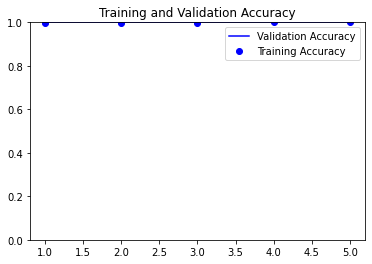

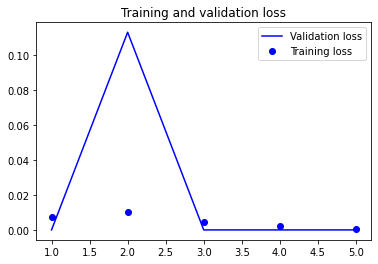

Bin  14 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 12s 120ms/step - loss: 9.5592e-04 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 11s 109ms/step - loss: 6.9450e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 11s 114ms/step - loss: 6.6546e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 11s 113ms/step - loss: 0.0113 - acc: 0.9965 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 11s 107ms/step - loss: 0.0126 - acc: 0.9970 - val_loss: 0.0000e+00 - val_acc: 1.0000


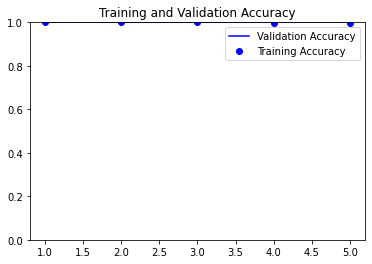

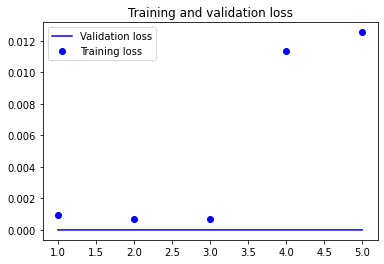

Bin  15 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 12s 120ms/step - loss: 0.0017 - acc: 0.9990 - val_loss: 2.9802e-08 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 11s 111ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 1.3256e-04 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 12s 115ms/step - loss: 0.0025 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 11s 111ms/step - loss: 0.0038 - acc: 0.9985 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 11s 107ms/step - loss: 0.0016 - acc: 0.9995 - val_loss: 2.6046e-05 - val_acc: 1.0000


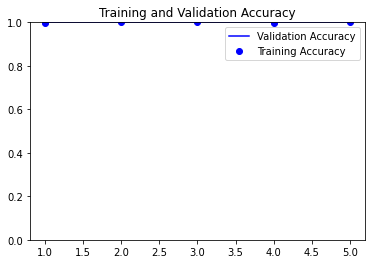

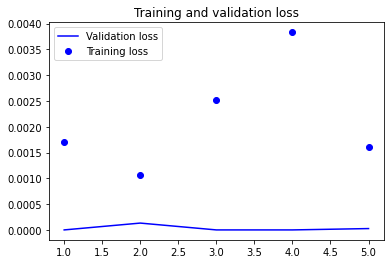

Bin  16 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 12s 120ms/step - loss: 0.0024 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 11s 110ms/step - loss: 0.0017 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 12s 118ms/step - loss: 0.0025 - acc: 0.9990 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 11s 113ms/step - loss: 0.0142 - acc: 0.9980 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 11s 107ms/step - loss: 0.0114 - acc: 0.9980 - val_loss: 0.0000e+00 - val_acc: 1.0000


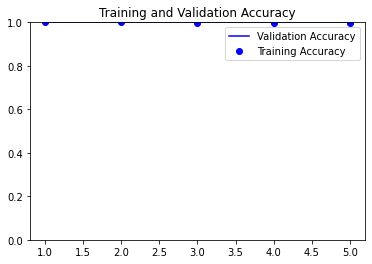

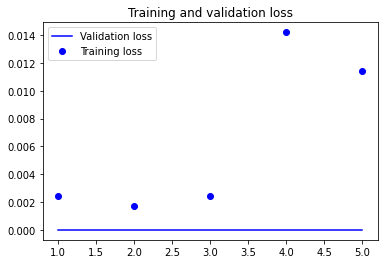

Bin  17 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 12s 120ms/step - loss: 0.0043 - acc: 0.9980 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 11s 108ms/step - loss: 0.0059 - acc: 0.9975 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 12s 116ms/step - loss: 5.2316e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 11s 112ms/step - loss: 5.3382e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 11s 110ms/step - loss: 0.0022 - acc: 0.9990 - val_loss: 2.1695e-05 - val_acc: 1.0000


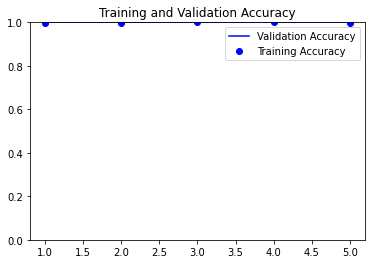

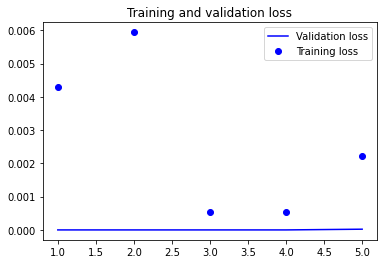

Bin  18 out of 20
Found 458 images belonging to 3 classes.
Found 25 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 13s 126ms/step - loss: 0.0023 - acc: 0.9995 - val_loss: 3.9816e-06 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 11s 110ms/step - loss: 0.0018 - acc: 0.9995 - val_loss: 2.3842e-08 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 12s 120ms/step - loss: 3.6204e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 11s 113ms/step - loss: 0.0021 - acc: 0.9995 - val_loss: 5.0068e-07 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 11s 113ms/step - loss: 3.3784e-04 - acc: 1.0000 - val_loss: 5.2452e-07 - val_acc: 1.0000


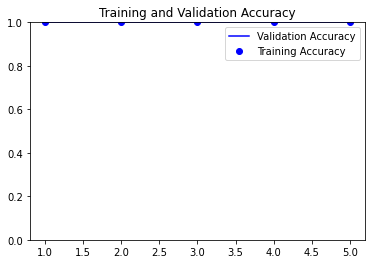

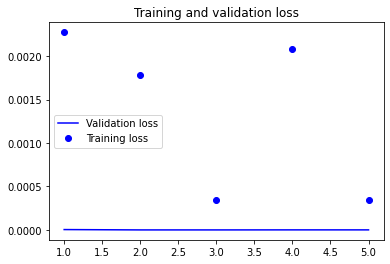

Bin  19 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 12s 120ms/step - loss: 0.0016 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 11s 109ms/step - loss: 0.0014 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 12s 116ms/step - loss: 0.0047 - acc: 0.9985 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 11s 112ms/step - loss: 0.0092 - acc: 0.9980 - val_loss: 3.1127e-04 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 11s 108ms/step - loss: 0.0237 - acc: 0.9940 - val_loss: 0.0000e+00 - val_acc: 1.0000


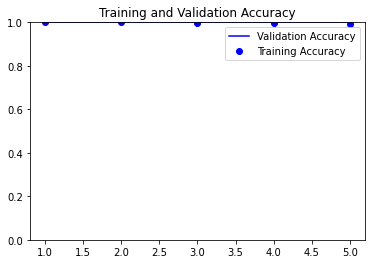

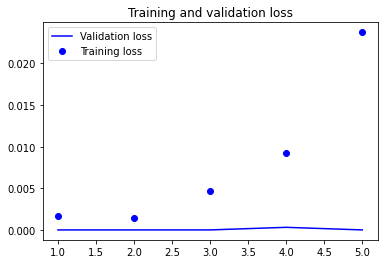

Bin  20 out of 20
Found 458 images belonging to 3 classes.
Found 25 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 12s 120ms/step - loss: 0.0094 - acc: 0.9980 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 11s 111ms/step - loss: 0.0111 - acc: 0.9975 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 12s 115ms/step - loss: 0.0053 - acc: 0.9970 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 11s 112ms/step - loss: 0.0069 - acc: 0.9970 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 11s 106ms/step - loss: 0.0026 - acc: 0.9990 - val_loss: 0.0000e+00 - val_acc: 1.0000


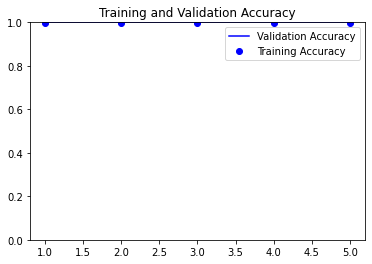

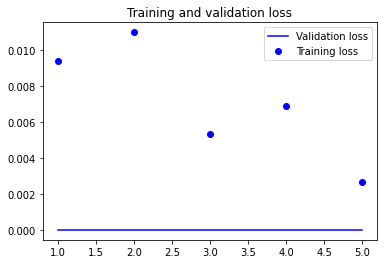

[0.0, 0.9430894255638123]

In [25]:
model3 = models.Sequential()
model3.add(layers.Conv2D(256, (3, 3), activation='relu', 
                         padding='same', 
                         input_shape=(64, 64, 3)))
model3.add(layers.MaxPooling2D((2,2)))
model3.add(layers.Conv2D(128, (3, 3), activation='relu',
                        padding='same'))
model3.add(layers.MaxPooling2D((2,2)))
model3.add(layers.Flatten())
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(32, activation='relu'))
model3.add(layers.Dense(3, activation='softmax'))

model3.summary()

model3.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['acc'])

run_k_fold_cross_val(model3, 20, steps_per_epoch=100, epochs=5, validation_steps=50)
model3.evaluate_generator(test_gen)

In [26]:
model3.evaluate_generator(test_gen)

[0.0, 0.9430894255638123]

In [0]:
return_data(img_dir, trn_dir, val_dir)

In [0]:
split_data(img_dir, trn_dir, val_dir, 0.1)

In [29]:
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir, target_size=(64, 64),
                                         batch_size=50, class_mode='categorical')

Found 547 images belonging to 3 classes.


In [30]:
model3.evaluate_generator(test_gen)

[0.0, 0.9890310764312744]

In [31]:
model2.evaluate_generator(test_gen)

[0.0, 0.9926874041557312]

In [32]:
model.evaluate_generator(test_gen)

[2.5363677824685738e-09, 0.9890310764312744]

In [0]:
x, y = test_gen.next()
model3.predict_generator(test_gen)

array([[1.0000000e+00, 1.3574066e-12, 1.6658501e-12],
       [1.0000000e+00, 1.9578889e-16, 1.7647826e-15],
       [1.0000000e+00, 7.8805675e-22, 5.2325610e-20],
       ...,
       [1.0000000e+00, 2.3888218e-22, 5.5332410e-22],
       [1.0000000e+00, 4.1323818e-22, 1.4296133e-20],
       [1.0000000e+00, 5.1440203e-18, 1.3705122e-17]], dtype=float32)

[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]


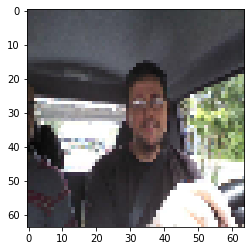

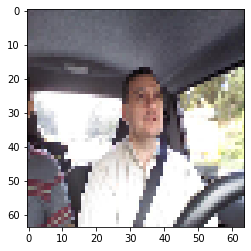

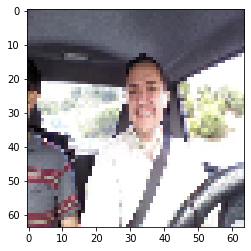

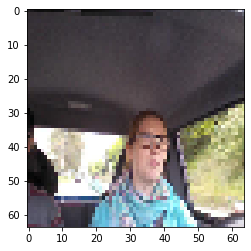

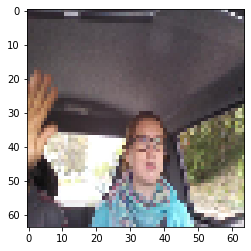

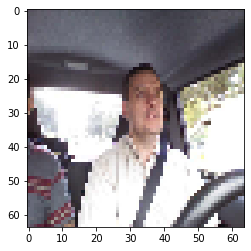

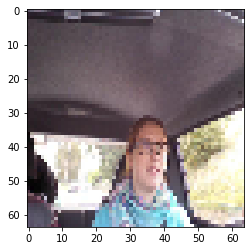

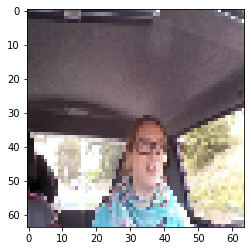

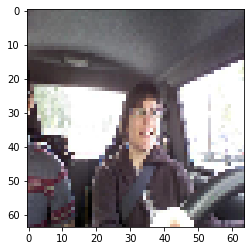

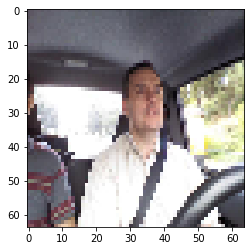

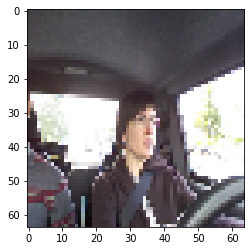

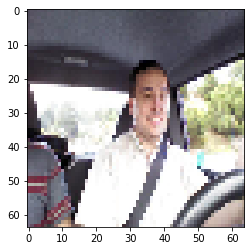

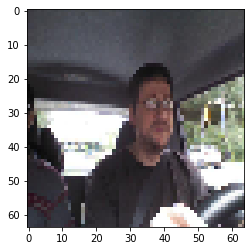

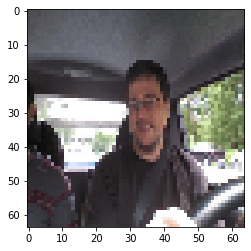

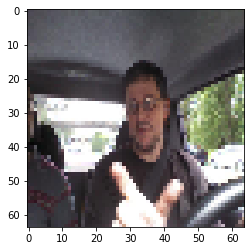

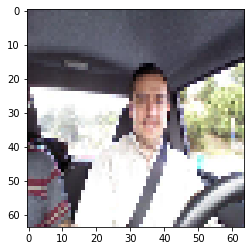

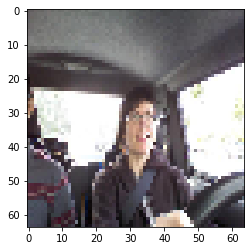

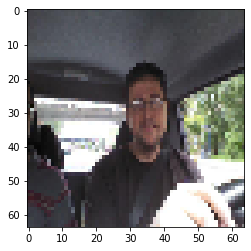

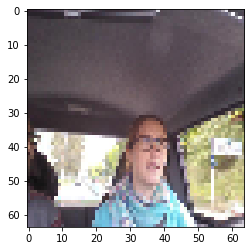

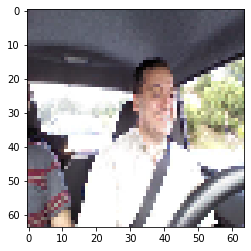

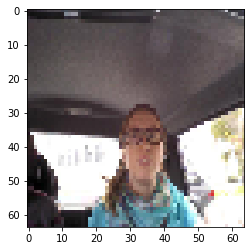

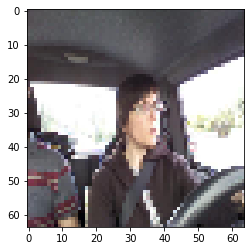

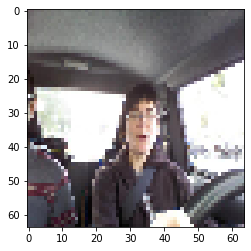

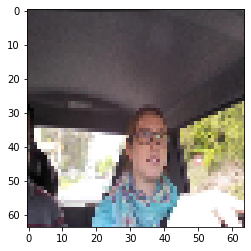

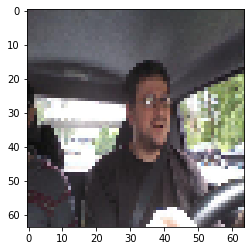

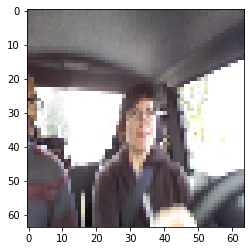

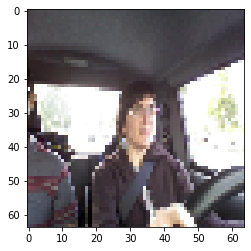

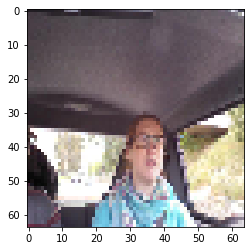

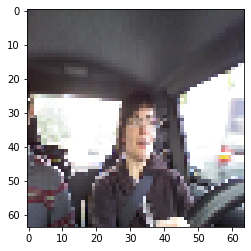

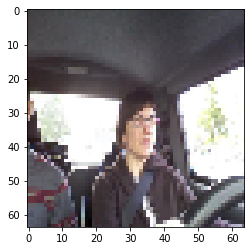

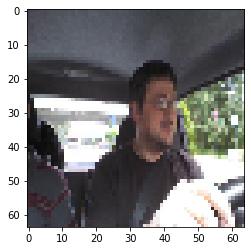

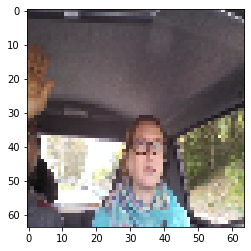

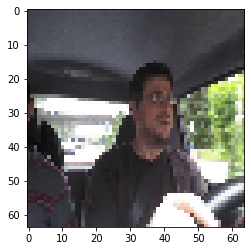

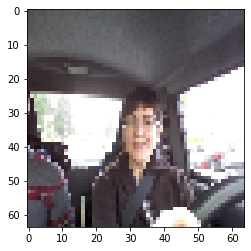

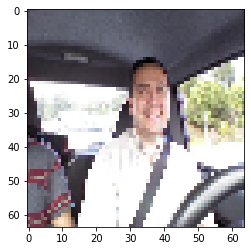

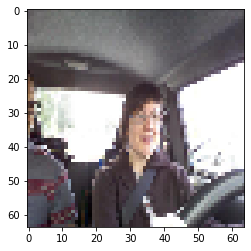

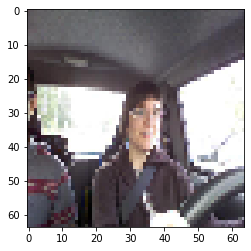

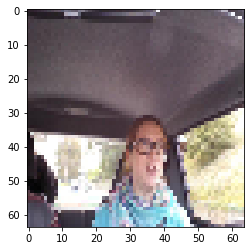

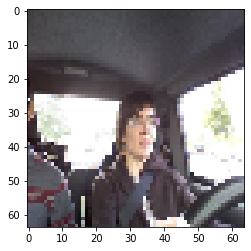

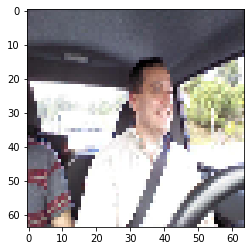

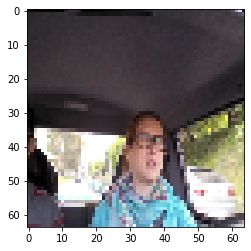

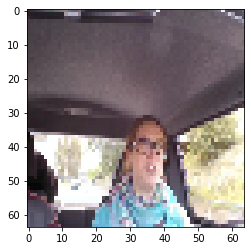

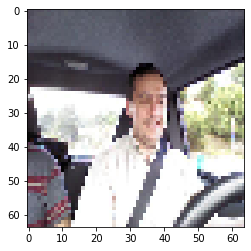

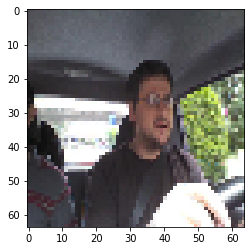

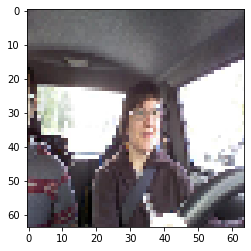

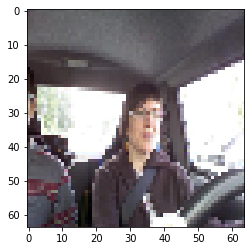

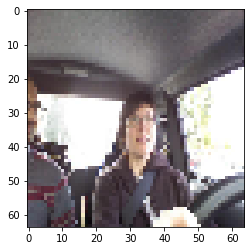

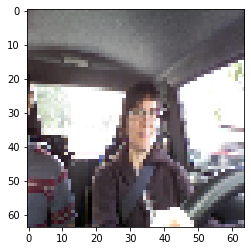

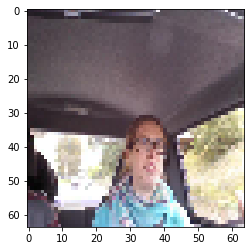

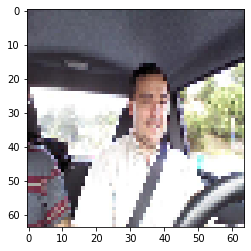

In [34]:
for i in range(len(x)):
  plt.figure()
  print(y[i], flush = True)
  plt.imshow(x[i], title)